This note book requires the following packages to run
* numpy
* sklearn
* tensorflow
* matplotlib
* scipy

To reproduce the exact results within the reported run time, a graphic card with computute capability of at least 5.2 is required.

Please put the training data and testing data in the same folder with this notebook and rename them to "train.mat" and "test.mat" respectively.

In [1]:
import scipy.io as sio
from sklearn import preprocessing
import numpy as np
import parmap

from __future__ import division

lb = preprocessing.LabelBinarizer()
lb.fit([1,2,3,4,5,6,7,8,9,10])
train = sio.loadmat("train.mat")
test = sio.loadmat("test.mat")
label = train['y']
img = train['X']
img = np.rollaxis(img,3,0)

label = np.ravel(label)
# Process the label so that it can be read by tensorflow
label = lb.transform(label)

Xtest = test['X']
Xtest = np.rollaxis(Xtest, 3,0)
ytest = test['y']
ytest = np.ravel(ytest)
ytest = lb.transform(ytest)

print img.shape, label.shape

(73257, 32, 32, 3) (73257, 10)


In [2]:

def process_(i, img):
    currentImg = img[i,:,:,:]

    # Grayscale image
    grayscale = np.dot(currentImg[:,:,:3], [0.299, 0.587, 0.114])

    return np.ravel(grayscale)

num_img = img.shape[0]
num_img_test = Xtest.shape[0]
processed = parmap.map(process_, range(0,num_img), img)
processed = np.array(processed)
test_processed = parmap.map(process_, range(0,num_img_test), Xtest)
test_processed = np.array(test_processed)

In [3]:
# batch = tf.train.shuffle_batch([img, label], batch_size=100, capacity=50000, 
#                                num_threads=4, min_after_dequeue=10000)
# batch[0].shape
# batch[1].shape
print test_processed.shape
print ytest.shape

(26032, 1024)
(26032, 10)


In [4]:
# Function to get batch of data
class SVHN:
    lb = preprocessing.LabelBinarizer()
    lb.fit([1,2,3,4,5,6,7,8,9,10])
    def __init__(self, data):
#         self.data = sio.loadmat(filename)
        self.img = data[0]
        self.label = data[1]
#         self.label = SVHN.lb.transform(np.ravel(self.label))
        self.indx = np.arange(self.label.shape[0])
#         self.state = np.random.RandomState(42)
#         self.batchsize = batchsize
#         self.num_batch = 
    def get_next_batch(self,batchsize):
        np.random.shuffle(self.indx)
        return self.img[self.indx[:batchsize],:], self.label[self.indx[:batchsize],:]
mysvhn = SVHN([processed, label])


(100, 1024) (100, 10)
[0 0 0 0 0 0 0 1 0 0]


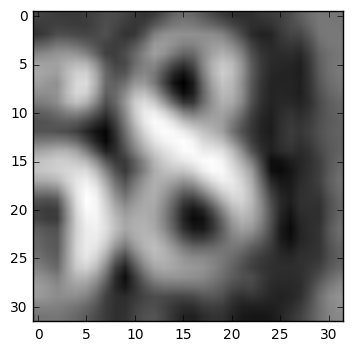

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

batch = mysvhn.get_next_batch(100)
print batch[0].shape, batch[1].shape
plt.imshow(batch[0][3,:].reshape([32,32]),cmap='gray')
print batch[1][3]

In [6]:
# #Test cell
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# batch = mnist.train.next_batch(100)
# print batch[0].shape
# print batch[1].shape

In [7]:
import tensorflow as tf
from sklearn import metrics
import numpy as np
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


# Initialize weight with randomized number drawn from normal distribition
def init_weight(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.1), name=name)
# Initialize bias with constant
def init_bias(shape, name):
    return tf.Variable(tf.constant(0.1, shape=shape), name=name)

# 2D convolution
def conv2d(x,w):
    """
    X is input tensor, W * H * D * n
    w is weight tensor, W' * H' * D * N
    return out, W * H * N
    padding='same'
    stride=[1,1,1,1]
    """
    return tf.nn.conv2d(x,w, strides=[1,1,1,1], padding='SAME',name="Convolution");

# Max pooling layer
def max_pool_2x2(x):
    """
    2 by 2 max pool
    filter size: 2 by 2
    stride: 2, 2
    padding='same'
    """
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")


## Define network structure

In [8]:
def model(x, w, b, keep_prob):
    """
    X is input tensor: 28 * 28 * 1 * n
    w is list of tensors of weight, len(w)=4 for this architecture
    b is list of bias, len(b)=4 correspondingly
    """
    x = tf.reshape(x,[-1, 32, 32, 1])
    
    # 2 Layers network, each layer contains a convolution, reLU and Max pool operation
    
    # Layer 1
    with tf.name_scope("Layer1"):
        with tf.name_scope("Convolutional_layer1"):
            h_conv1 = (conv2d(x, w[0]) + b[0])
        with tf.name_scope("ReLU_layer1"):
            h_relu1 = tf.nn.relu(h_conv1)
        with tf.name_scope("Max_pooling_layer1"):
            h_pool1 = max_pool_2x2(h_relu1)
        
    # Layer 2
    with tf.name_scope("Layer2"):
        with tf.name_scope("Convolutional_layer2"):
            h_conv2 = conv2d(h_pool1, w[1]) + b[1]
        with tf.name_scope("ReLU_layer2"):
            h_relu2 = tf.nn.relu(h_conv2)
        with tf.name_scope("Max_pooling_layer2"):
            h_pool2 = max_pool_2x2(h_relu2)
    
    # Reshape h_pool2
    h_pool2 = tf.reshape(h_pool2,[-1, 8*8*64])
    
    # Fully connected layer
    with tf.name_scope("Fully_Connected_layer"):
        with tf.name_scope("Activation_layer"):
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2, w[2]) + b[2])
#         keep_prob = tf.placeholder(tf.float32)
        with tf.name_scope("Dropout"):
            h_drop = tf.nn.dropout(h_fc1, keep_prob)
        with tf.name_scope("Read_out_layer"):
            y_conv = tf.matmul(h_drop, w[3]) + b[3]
    return y_conv

## Initialize weights and bias

In [9]:
# Input images
x = tf.placeholder(tf.float32, shape=[None,32*32], name="Input_images")

# Input labels
y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Input_labels")

# Weights and bias for layer 1
w_0 = init_weight([3,3,1,32],"Layer1_weights")
b_0 = init_bias([32], "Layer1_bias")

# Weights and bias for layer 2
w_1 = init_weight([5,5,32,64], "Layer2_weights")
b_1 = init_bias([64], "Layer2_bias")

# Weights and bias for fully connected layer 1
w_2 = init_weight([8*8*64, 1024], "Fully_connected_layer_weight1")
b_2 = init_bias([1024],"Fully_connected_layer_bias1")

# Weights and bias for fully connected layer 2
w_3 = init_weight([1024, 10], "Read_out_weight")
b_3 = init_bias([10], "Read_out_bias")

# Add summary for later visualization and analysis
tf.histogram_summary("w_0_summ", w_0)
tf.histogram_summary("w_1_summ", w_1)
tf.histogram_summary("w_2_summ", w_2)
tf.histogram_summary("w_3_summ", w_3)

tf.histogram_summary("b_0_summ", b_0)
tf.histogram_summary("b_1_summ", b_1)
tf.histogram_summary("b_2_summ", b_2)
tf.histogram_summary("b_3_summ", b_3)

keep_prob = tf.placeholder(tf.float32, name="keeping_probability")

In [10]:
y_h = model(x,[w_0,w_1,w_2,w_3],[b_0,b_1,b_2,b_3], keep_prob)

# Cost function
with tf.name_scope("Cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_h, y_))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)
    # Add summary of cost
    tf.scalar_summary("Cost", cost)

# Accuracy function
with tf.name_scope("Accuracy"):
    correct = tf.equal(tf.argmax(y_h,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    tf.scalar_summary("Accuracy", accuracy)

# with tf.InteractiveSession() as sess:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

writer = tf.train.SummaryWriter("logs/", sess.graph)
merged = tf.merge_all_summaries()
tf.global_variables_initializer().run()



In [11]:
# Start training
for i in xrange(500000):
    batch = mysvhn.get_next_batch(100)
    sess.run(train_step, feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob:1.0})
        summary, acc = sess.run([merged, accuracy], feed_dict={x:batch[0], y_:batch[1], keep_prob:1.0})
        writer.add_summary(summary, i)
        print "Step {}, training accuracy {}".format(i, train_accuracy)


Step 0, training accuracy 0.0999999940395
Step 100, training accuracy 0.139999985695
Step 200, training accuracy 0.280000001192
Step 300, training accuracy 0.289999991655
Step 400, training accuracy 0.25
Step 500, training accuracy 0.209999978542
Step 600, training accuracy 0.179999992251
Step 700, training accuracy 0.209999978542
Step 800, training accuracy 0.239999979734
Step 900, training accuracy 0.239999979734
Step 1000, training accuracy 0.209999993443
Step 1100, training accuracy 0.159999996424
Step 1200, training accuracy 0.179999992251
Step 1300, training accuracy 0.139999985695
Step 1400, training accuracy 0.179999992251
Step 1500, training accuracy 0.179999992251
Step 1600, training accuracy 0.219999998808
Step 1700, training accuracy 0.199999988079
Step 1800, training accuracy 0.209999993443
Step 1900, training accuracy 0.139999985695
Step 2000, training accuracy 0.240000009537
Step 2100, training accuracy 0.209999993443
Step 2200, training accuracy 0.119999997318
Step 2300

KeyboardInterrupt: 

In [12]:
# save_path = saver.save(sess, "variables/CNN_500000.ckpt")

In [11]:
# Test cell

import numpy as np
import pandas as pd

# test_img = mnist.test.images
# test_label = mnist.test.labels
# print test_img.shape

# res = tf.pack(tf.argmax(y_h,1), tf.argmax(y_,1))
confusion = np.zeros([10,10], int)
saver.restore(sess, "variables/CNN_500000.ckpt")
temp_accuracy = []
predicted = tf.argmax(y_h,1)
temp_result = []
for i in xrange(0,test_processed.shape[0],100):
    top = min(ytest.shape[0], i+100)
    temp = accuracy.eval(feed_dict={x: test_processed[i:top,:], y_: ytest[i:top,:], 
                                    keep_prob: 1.0})
    temp_accuracy.append(temp)
    print("temp accuracy %g"%temp)
#     ans = res.eval(feed_dict={x: test_img[i:i+100,:], y_: test_label[i:i+100], 
#                                     keep_prob: 1.0})
#     for p in ans.T:
#         confusion[p[0], p[1]]+=1
    temp_result.append(predicted.eval(feed_dict={x:test_processed[i:i+100,:], y_: ytest[i:i+100,:], 
                                    keep_prob: 1.0}))



temp accuracy 0.9
temp accuracy 0.87
temp accuracy 0.81
temp accuracy 0.94
temp accuracy 0.9
temp accuracy 0.94
temp accuracy 0.89
temp accuracy 0.91
temp accuracy 0.85
temp accuracy 0.91
temp accuracy 0.86
temp accuracy 0.94
temp accuracy 0.93
temp accuracy 0.88
temp accuracy 0.87
temp accuracy 0.86
temp accuracy 0.93
temp accuracy 0.9
temp accuracy 0.92
temp accuracy 0.96
temp accuracy 0.88
temp accuracy 0.91
temp accuracy 0.89
temp accuracy 0.94
temp accuracy 0.91
temp accuracy 0.88
temp accuracy 0.86
temp accuracy 0.92
temp accuracy 0.91
temp accuracy 0.89
temp accuracy 0.91
temp accuracy 0.98
temp accuracy 0.93
temp accuracy 0.92
temp accuracy 0.9
temp accuracy 0.97
temp accuracy 0.89
temp accuracy 0.93
temp accuracy 0.93
temp accuracy 0.87
temp accuracy 0.94
temp accuracy 0.89
temp accuracy 0.94
temp accuracy 0.94
temp accuracy 0.91
temp accuracy 0.9
temp accuracy 0.89
temp accuracy 0.91
temp accuracy 0.85
temp accuracy 0.91
temp accuracy 0.96
temp accuracy 0.91
temp accuracy 0.9

Overall accuracy 0.904324710369
Confusion matrix 
[[ 94.86   0.82   0.71   1.06   0.18   0.16   1.27   0.27   0.12   0.55]
 [  1.01  93.25   1.88   0.7    0.65   0.1    1.42   0.39   0.41   0.19]
 [  3.09   2.29  86.26   0.49   2.6    0.66   0.66   1.25   2.46   0.24]
 [  3.33   1.59   0.75  92.07   0.36   0.36   0.24   0.36   0.59   0.36]
 [  1.01   0.84   3.78   0.63  89.3    1.76   0.38   0.84   1.22   0.25]
 [  1.37   0.51   1.47   1.42   2.23  88.01   0.56   1.97   0.51   1.97]
 [  5.15   1.83   0.99   0.2    0.59   0.15  90.49   0.1    0.25   0.25]
 [  1.2    0.9    3.01   0.84   1.81   5.42   0.42  81.93   3.25   1.2 ]
 [  1.07   3.32   1.32   0.82   1.69   0.25   0.75   1.07  87.96   1.76]
 [  1.66   1.61   1.26   0.29   0.23   2.41   0.52   0.52   1.89  89.62]]


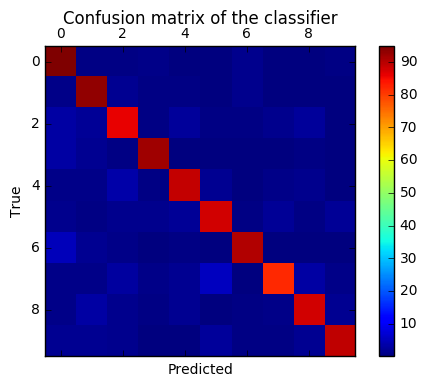

In [14]:
from sklearn.metrics import classification_report

np.set_printoptions(precision=2, suppress=True)

ytest = test['y']
ytest = np.ravel(ytest)
b = np.hstack(temp_result) + 1

# mnist_ = input_data.read_data_sets('MNIST_data', one_hot=False)
# test_label = mnist_.test.labels
# print test_label

# print "Confusion matrix \n{}".format(metrics.confusion_matrix(test_label, b))
names=['1','2','3','4','5','6','7','8','9','10']
names1=[1,2,3,4,5,6,7,8,9,10]

print "Classification report \n{}".format(classification_report())

temp_accuracy_ = np.array(temp_accuracy)
print "Overall accuracy {}".format(np.mean(temp_accuracy_))
conf_mat = metrics.confusion_matrix(ytest, b)
conf_mat1 = conf_mat/conf_mat.sum(axis=1)[:,None]*100
print "Confusion matrix \n{}".format(conf_mat1)
# print "{}".format(conf_mat)
# print np.min(b)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat1)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels(names1)
# ax.set_yticklabels(names1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
fig.savefig('foo.png')

In [38]:
print np.sum(conf_mat1, axis=1)
print tot


[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[5099 4149 2882 2523 2384 1977 2019 1660 1595 1744]
